# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, stddev, split, udf, isnull, first, col, format_number, rand, desc
from pyspark.sql.functions import min as Fmin
from pyspark.sql.functions import max as Fmax
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import IntegerType, FloatType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier,RandomForestClassifier, LinearSVC
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [2]:
# create a Spark session
import re
import copy
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

%matplotlib inline

In [3]:
#set seaborn
sns.set()

In [4]:
# Create spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .enableHiveSupport() \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
df = spark.read.json('mini_sparkify_event_data.json')
df.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

## Basic Data Analysis and Statistics Exploration
1. Explore the columns this dataset contains
2. Explore the basic statistics this dataset shows
3. Explore the main features this dataset contains 

In [6]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
# Describe the statistics of the dataset in different columns
# artist:
df.describe('artist').show()

+-------+------------------+
|summary|            artist|
+-------+------------------+
|  count|            228108|
|   mean| 551.0852017937219|
| stddev|1217.7693079161374|
|    min|               !!!|
|    max| ÃÂlafur Arnalds|
+-------+------------------+



In [8]:
# sessionId:
df.describe('sessionId').show()

+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630741|
|    min|                1|
|    max|             2474|
+-------+-----------------+



In [9]:
# userId:
df.describe('userId').show()

+-------+-----------------+
|summary|           userId|
+-------+-----------------+
|  count|           286500|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|                 |
|    max|               99|
+-------+-----------------+



In [10]:
# Show the options in page column
df.select("page").dropDuplicates().sort("page").show(50)

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



## Data Wrangling
1. Drop rows with missing values in UserId and SessionId
2. Drop rows with empty string values in UserId
3. Convert the datetime into hours

In [11]:
df_valid = df.dropna(how = "any", subset = ["userId", "sessionId"])

In [12]:
df_valid = df_valid.fillna(0, subset=['length'])

In [13]:
df_valid.show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Bost

In [14]:
df_valid.filter(df["sessionId"] == "").count()

0

In [15]:
df_valid.filter(df["userId"] == "").count()

8346

In [16]:
df_valid = df_valid.filter(df_valid["userId"] != "")

In [17]:
df_valid.count()

278154

In [18]:
# Create a lambda function for formating the timestamp
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

# Apply the udf on the ts column
df_valid = df_valid.withColumn("timestamp", get_time(df_valid.ts))

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

In [19]:
#Create a temporary view to perform SQL operations
df_valid.createOrReplaceTempView("Sparkify_valid")

* Exploring gender column

In [20]:
gender_count = spark.sql('''
        SELECT gender, COUNT(DISTINCT userId) AS user_count
        FROM Sparkify_valid
        GROUP BY gender
        ORDER BY user_count DESC
''')
gender_count.show()

+------+----------+
|gender|user_count|
+------+----------+
|     M|       121|
|     F|       104|
+------+----------+



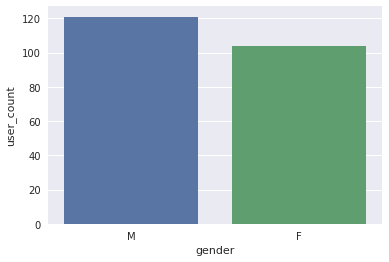

In [21]:
sns.barplot(x='gender',y='user_count', data=gender_count.toPandas())

There are 12 males and 104 females in this dataset, and one without gender declaration

* Exploring length column and display the distribution plot for the length

In [22]:
length_count = spark.sql('''
        SELECT length
        FROM Sparkify_valid
''')

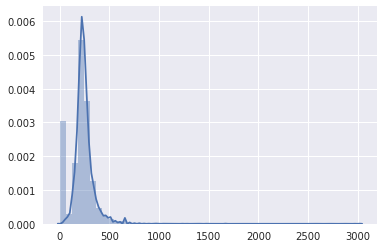

In [23]:
sns.distplot(length_count.toPandas().dropna());

* Exploring level of users from the dataset

In [24]:
level_count = spark.sql('''
        SELECT level, COUNT(DISTINCT userId) AS user_count
        FROM Sparkify_valid
        GROUP BY level
        ORDER BY user_count DESC
''')
level_count.show()

+-----+----------+
|level|user_count|
+-----+----------+
| free|       195|
| paid|       165|
+-----+----------+



* Exploring the top 5 location of users distribution

In [25]:
location_count = spark.sql('''
        SELECT location, COUNT(DISTINCT userId) AS user_count
        FROM Sparkify_valid
        GROUP BY location
        ORDER BY user_count DESC
''')
location_count.show()

+--------------------+----------+
|            location|user_count|
+--------------------+----------+
|Los Angeles-Long ...|        16|
|New York-Newark-J...|        15|
|Dallas-Fort Worth...|         7|
|Phoenix-Mesa-Scot...|         7|
|    St. Louis, MO-IL|         6|
|Chicago-Napervill...|         6|
|Charlotte-Concord...|         6|
|Philadelphia-Camd...|         5|
|Miami-Fort Lauder...|         5|
|Boston-Cambridge-...|         5|
|Atlanta-Sandy Spr...|         4|
|Washington-Arling...|         4|
|Houston-The Woodl...|         4|
|San Diego-Carlsba...|         3|
|Las Vegas-Henders...|         3|
|New Haven-Milford...|         3|
|Providence-Warwic...|         2|
|San Antonio-New B...|         2|
|Indianapolis-Carm...|         2|
|         Jackson, MS|         2|
+--------------------+----------+
only showing top 20 rows



* Exploring the page infomation of users

In [26]:
page_count = spark.sql('''
        SELECT page, COUNT(DISTINCT userId) AS user_count
        FROM Sparkify_valid
        GROUP BY page
        ORDER BY user_count DESC
''')
page_count.show()

+--------------------+----------+
|                page|user_count|
+--------------------+----------+
|            NextSong|       225|
|                Home|       223|
|           Thumbs Up|       220|
|     Add to Playlist|       215|
|              Logout|       213|
|         Roll Advert|       207|
|          Add Friend|       206|
|         Thumbs Down|       203|
|            Settings|       195|
|                Help|       192|
|             Upgrade|       168|
|               About|       155|
|           Downgrade|       154|
|       Save Settings|       132|
|      Submit Upgrade|       131|
|               Error|       117|
|              Cancel|        52|
|Cancellation Conf...|        52|
|    Submit Downgrade|        49|
+--------------------+----------+



* Exploring the userAgent (platforms) of users preference

In [27]:
def get_browser(x):
    if 'Firefox' in x:
        return 'Firefox'
    elif 'Safari' in x:
        if 'Chrome' in x:
            return 'Chrome'
        else:
            return 'Safari'
    elif 'Trident' in x:
        return 'IE'
    else:
        return 'Others'

In [28]:
def get_platform(x):
    if ('compatible' in x) or ('Windows' in x):
        return 'Windows'
    elif 'iPhone' in x:
        return 'iPhone'
    elif 'iPad' in x:
        return 'iPad'
    elif 'X11' in x:
        return 'Linux'
    elif 'Macintosh' in x:
        return 'Mac'
    else:
        return 'Others'

In [29]:
userAgent_count = spark.sql('''
        SELECT userAgent, COUNT(DISTINCT userId) AS user_count
        FROM Sparkify_valid
        GROUP BY userAgent
        ORDER BY user_count DESC
''').toPandas()

In [30]:
userAgent_count = userAgent_count.dropna()

In [31]:
userAgent_count['browser'] = userAgent_count['userAgent'].apply(get_browser)

In [32]:
userAgent_count['platform'] = userAgent_count['userAgent'].apply(get_platform)

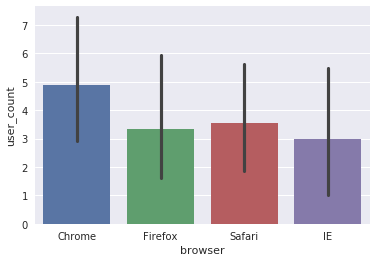

In [33]:
sns.barplot(x='browser',y='user_count', data=userAgent_count)

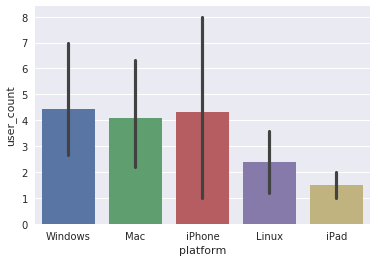

In [34]:
sns.barplot(x='platform',y='user_count', data=userAgent_count)

* Exploring the time statistics in users

In [35]:
df_valid.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', timestamp='2018-10-01 00:01:57')]

In [36]:
hour_data = spark.sql('''
        SELECT hour(timestamp) AS hour, COUNT(DISTINCT userId) AS user_count
        FROM Sparkify_valid
        GROUP BY hour
        ORDER BY user_count DESC
''').toPandas()

In [37]:
weekday_data = spark.sql('''
        SELECT dayofweek(timestamp) AS weekday, COUNT(DISTINCT userId) AS user_count
        FROM Sparkify_valid
        GROUP BY weekday
        ORDER BY user_count DESC
''').toPandas()

In [38]:
monthday_data = spark.sql('''
        SELECT dayofmonth(timestamp) AS monthday, COUNT(DISTINCT userId) AS user_count
        FROM Sparkify_valid
        GROUP BY monthday
        ORDER BY user_count DESC
''').toPandas()

In [39]:
month_data = spark.sql('''
        SELECT month(timestamp) AS month, COUNT(DISTINCT userId) AS user_count
        FROM Sparkify_valid
        GROUP BY month
        ORDER BY user_count DESC
''').toPandas()

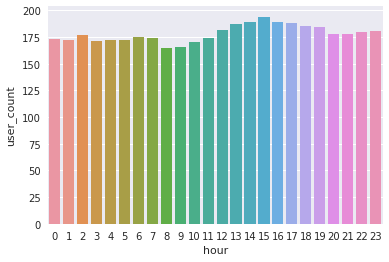

In [40]:
sns.barplot(x='hour',y='user_count', data=hour_data)

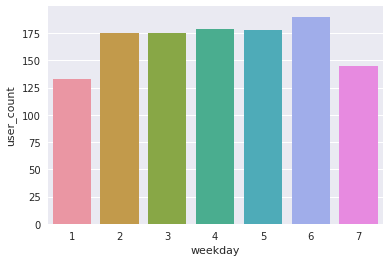

In [41]:
sns.barplot(x='weekday',y='user_count', data=weekday_data)

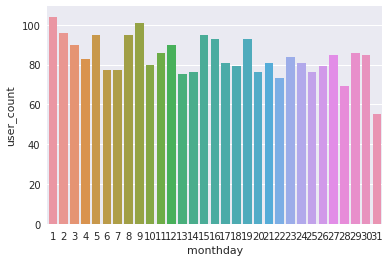

In [42]:
sns.barplot(x='monthday',y='user_count', data=monthday_data)

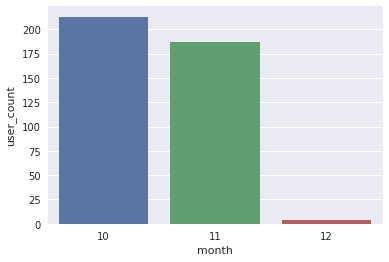

In [43]:
sns.barplot(x='month',y='user_count', data=month_data)

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [44]:
#define the churn event flag lambda function
flag_churn_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())

In [45]:
#define the churn column and corresponding status
df_valid = df_valid.withColumn("churn_flag", flag_churn_event("page"))

In [46]:
df_valid.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', timestamp='2018-10-01 00:01:57', churn_flag=0)

In [47]:
#mark the user who have churned event
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [48]:
df_valid = df_valid.withColumn("churn", Fsum("churn_flag").over(windowval))

In [49]:
df_valid.take(1)

[Row(artist=None, auth='Logged In', firstName='Darianna', gender='F', itemInSession=34, lastName='Carpenter', length=0.0, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', timestamp='2018-11-21 18:12:32', churn_flag=0, churn=0)]

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [50]:
#Create a temporary view to perform SQL operations
df_valid.createOrReplaceTempView("Sparkify_valid_churn")

In [51]:
#Check the active users and the churned users
churn_data = spark.sql('''
        SELECT churn, COUNT(DISTINCT userId) AS user_count
        FROM Sparkify_valid_churn
        GROUP BY churn
        ORDER BY user_count DESC
''')
churn_data.show()

+-----+----------+
|churn|user_count|
+-----+----------+
|    0|       173|
|    1|        52|
+-----+----------+



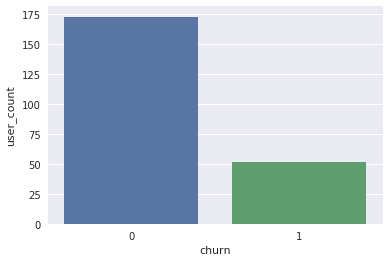

In [52]:
sns.barplot(x='churn',y='user_count', data=churn_data.toPandas())

In [53]:
gender_churn = spark.sql('''
        SELECT churn, gender, COUNT(DISTINCT userId) AS user_count
        FROM Sparkify_valid_churn
        GROUP BY churn, gender
        ORDER BY user_count DESC
''').toPandas()

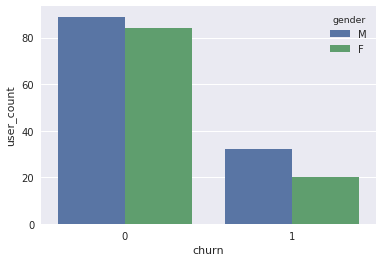

In [54]:
sns.barplot(x='churn',y='user_count', hue='gender', data=gender_churn)

In [55]:
spark.sql('''
        SELECT churn, AVG(length) AS avglen, STDDEV(length) AS stddevlen, MAX(length), MIN(length)
        FROM Sparkify_valid_churn
        GROUP BY churn
''').show()

+-----+------------------+------------------+-----------+-----------+
|churn|            avglen|         stddevlen|max(length)|min(length)|
+-----+------------------+------------------+-----------+-----------+
|    0|204.79609148240368|130.72565173739812| 3024.66567|        0.0|
|    1|201.69271497570438| 134.0569567109882| 3024.66567|        0.0|
+-----+------------------+------------------+-----------+-----------+



In [56]:
spark.sql('''
        SELECT churn, level, COUNT(DISTINCT userId) AS user_count
        FROM Sparkify_valid_churn
        GROUP BY churn, level
''').show()

+-----+-----+----------+
|churn|level|user_count|
+-----+-----+----------+
|    1| paid|        36|
|    1| free|        46|
|    0| free|       149|
|    0| paid|       129|
+-----+-----+----------+



In [57]:
spark.sql('''
        SELECT churn, page, COUNT(page) AS count
        FROM Sparkify_valid_churn
        GROUP BY churn, page
        ORDER BY page, count
''').show(100)

+-----+--------------------+------+
|churn|                page| count|
+-----+--------------------+------+
|    1|               About|    56|
|    0|               About|   439|
|    1|          Add Friend|   636|
|    0|          Add Friend|  3641|
|    1|     Add to Playlist|  1038|
|    0|     Add to Playlist|  5488|
|    1|              Cancel|    52|
|    1|Cancellation Conf...|    52|
|    1|           Downgrade|   337|
|    0|           Downgrade|  1718|
|    1|               Error|    32|
|    0|               Error|   220|
|    1|                Help|   239|
|    0|                Help|  1215|
|    1|                Home|  1672|
|    0|                Home|  8410|
|    1|              Logout|   553|
|    0|              Logout|  2673|
|    1|            NextSong| 36394|
|    0|            NextSong|191714|
|    1|         Roll Advert|   967|
|    0|         Roll Advert|  2966|
|    1|       Save Settings|    58|
|    0|       Save Settings|   252|
|    1|            Settings|

In [58]:
userAgent_count = spark.sql('''
        SELECT churn, userAgent, COUNT(DISTINCT userId) AS user_count
        FROM Sparkify_valid_churn
        GROUP BY churn, userAgent
        ORDER BY user_count DESC
''').toPandas()

In [59]:
userAgent_count = userAgent_count.dropna()

In [60]:
userAgent_count['browser'] = userAgent_count['userAgent'].apply(get_browser)
userAgent_count['platform'] = userAgent_count['userAgent'].apply(get_platform)

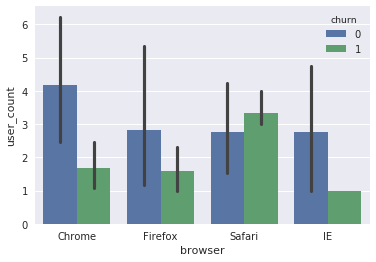

In [61]:
sns.barplot(x='browser',y='user_count', hue='churn', data=userAgent_count)

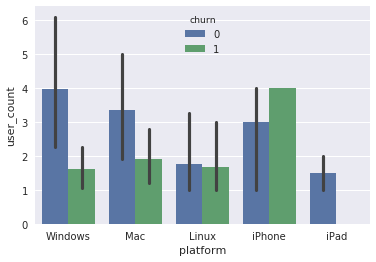

In [62]:
sns.barplot(x='platform',y='user_count', hue='churn', data=userAgent_count)

In [63]:
hour_data = spark.sql('''
        SELECT churn, hour(timestamp) AS hour, COUNT(churn) AS count
        FROM Sparkify_valid_churn
        GROUP BY churn, hour
''').toPandas()

In [64]:
weekday_data = spark.sql('''
        SELECT churn, dayofweek(timestamp) AS weekday, COUNT(churn) AS count
        FROM Sparkify_valid_churn
        GROUP BY churn, weekday
''').toPandas()

In [66]:
month_data = spark.sql('''
        SELECT churn, month(timestamp) AS month, COUNT(churn) AS count
        FROM Sparkify_valid_churn
        GROUP BY churn, month
''').toPandas()

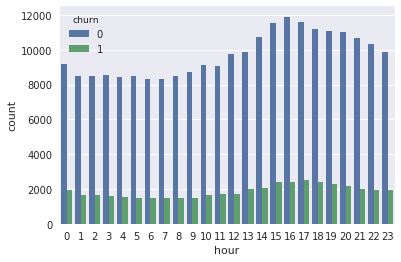

In [67]:
sns.barplot(x='hour',y='count', hue='churn', data=hour_data)

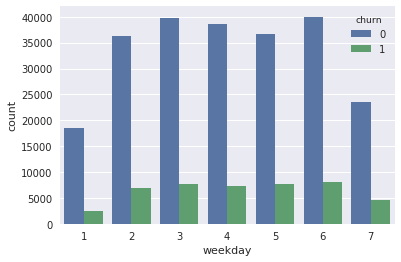

In [68]:
sns.barplot(x='weekday',y='count', hue='churn', data=weekday_data)

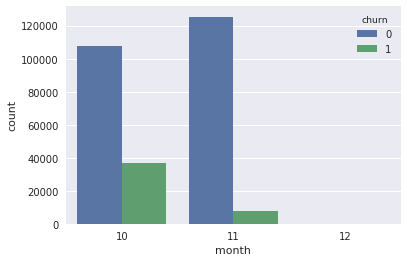

In [69]:
sns.barplot(x='month',y='count', hue='churn', data=month_data)

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

### Features Instructions
From the above schema of the dataset and the prelimnary data analysis, the significant features can be categorized as:
* Numerical Features:
    * mean, stddev, max and min of length
    * some options of pages: Downgrade, NextSong, ThumbsUp, AddtoPlaylist, Home, RollAdvert, AddFriend
    * hour
    * month
    * weekday
* Categorical Features:
    * gender
    * level
    * browser
    * platform

### Categorical Features: label encoding

In [70]:
get_browser = udf(get_browser)
get_platform = udf(get_platform)

In [71]:
df_valid = df_valid.withColumn("browser", get_browser(df_valid.userAgent))
df_valid = df_valid.withColumn("platform", get_platform(df_valid.userAgent))

In [72]:
# label_encoding code reference: https://github.com/CapAllen/Sparkify/blob/master/Sparkify.ipynb
def label_encoding(df, col_name):
    '''
    transform categorical items to number
    '''
    temp = df.select([col_name]).dropDuplicates().toPandas()
    label_dict = {val:str(idx) for idx,val in enumerate(temp[col_name].tolist())}
    result = df.dropDuplicates(['userId']).select(['userId',col_name]).replace(label_dict,subset=col_name)
    return result

In [73]:
encode_gender = label_encoding(df_valid, 'gender')
encode_level = label_encoding(df_valid, 'level')
encode_browser = label_encoding(df_valid, 'browser')
encode_platform = label_encoding(df_valid, 'platform')

In [74]:
cat_features = encode_gender.join(encode_level, on='userId',how='inner').\
                            join(encode_browser, on='userId',how='inner').\
                            join(encode_platform, on='userId',how='inner')

In [75]:
cat_features.show(5)

+------+------+-----+-------+--------+
|userId|gender|level|browser|platform|
+------+------+-----+-------+--------+
|100010|     0|    0|      1|       1|
|200002|     1|    0|      1|       1|
|   125|     1|    0|      3|       3|
|   124|     0|    1|      3|       3|
|    51|     1|    1|      3|       4|
+------+------+-----+-------+--------+
only showing top 5 rows



###  Numerical Features

In [76]:
#pivot table, reference url:https://stackoverflow.com/questions/56051438/pivot-table-in-pyspark
def get_pivot_table(colname, col_count, pivot_cols):
    col_pivot = col_count.groupby('userId').pivot(colname).agg(first('count')).fillna(0).select(pivot_cols)
    
    return col_pivot

In [77]:
def numerical_features():
    length_feature = spark.sql('''
    SELECT userId, AVG(length) AS avglen, STDDEV(length) AS stddevlen, MAX(length), MIN(length)
    FROM Sparkify_valid_churn
    GROUP BY userId
        ''')
    
    page_count = spark.sql('''
    SELECT userId, page, COUNT(userId) AS count
    FROM Sparkify_valid_churn
    GROUP BY userId, page
        ''')
    page_cols = ['userId', 'Downgrade', 'NextSong', 'Thumbs Up', 'Add to Playlist', 'Home', 'Roll Advert', 'Add Friend']
    page_pivot = get_pivot_table('page', page_count, page_cols)
    
    # timestamp hour
    hour_count = spark.sql('''
        SELECT userId, hour(timestamp) AS hour, COUNT(userId) AS count
        FROM Sparkify_valid_churn
        GROUP BY userId, hour
''')
    pivot_cols = ['userId']
    for i in range(0, 24):
        pivot_cols.append(str(i))
    hour_pivot = get_pivot_table('hour', hour_count, pivot_cols)
    
    # timestamp weekday
    weekday_count = spark.sql('''
        SELECT userId, date_format(timestamp, "EEE") AS weekday, COUNT(userId) AS count
        FROM Sparkify_valid_churn
        GROUP BY userId, weekday
''')
    pivot_cols = ['userId', 'Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
    weekday_pivot = get_pivot_table('weekday', weekday_count, pivot_cols)
    
    # timestamp month
    month_count = spark.sql('''
        SELECT userId, date_format(timestamp, "MMM") AS month, COUNT(userId) AS count
        FROM Sparkify_valid_churn
        GROUP BY userId, month
''')
    pivot_cols = ['userId', 'Oct', 'Nov', 'Dec']
    month_pivot = get_pivot_table('month', month_count, pivot_cols)
    
    result = length_feature.join(page_pivot,on='userId',how='inner').\
                        join(hour_pivot,on='userId',how='inner').\
                        join(weekday_pivot,on='userId',how='inner').\
                        join(month_pivot,on='userId',how='inner')
    
    return result

### Churn

In [78]:
churn = spark.sql('''
    SELECT DISTINCT userId, churn
    FROM Sparkify_valid_churn
        ''')

In [79]:
def get_training_data():
    num_features = numerical_features()
    result = cat_features.join(num_features,on='userId',how='inner').\
                        join(churn,on='userId',how='inner')
    
    return result

In [80]:
model_data = get_training_data()

In [83]:
model_data_pd = model_data.toPandas()

In [84]:
model_data_pd.shape

(225, 51)

In [85]:
model_data_pd.head()

,userId,gender,level,browser,platform,avglen,stddevlen,max(length),min(length),Downgrade,...,Mon,Tue,Wed,Thu,Fri,Sat,Oct,Nov,Dec,churn
0,100010,0,0,1,1,175.697893,128.410381,538.85342,0.0,0,...,121,55,33,0,112,60,164,217,0,0
1,200002,1,0,1,1,198.330962,116.218788,592.06485,0.0,5,...,86,96,0,292,0,0,334,140,0,0
2,125,1,0,3,3,189.919373,138.381904,391.26159,0.0,0,...,0,0,0,0,11,0,11,0,0,1
3,124,0,1,3,3,209.805615,128.034547,2369.04444,0.0,41,...,975,1000,623,599,1047,208,2618,2207,0,0
4,51,1,1,3,4,212.368443,130.048095,2594.87302,0.0,23,...,568,526,228,343,629,63,2464,0,0,1


# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [92]:
model_cols = list(model_data_pd.drop(columns = ['churn', 'userId']).columns)
categorical_cols = ['gender','level','browser','platform']
numerical_cols = [col_name for col_name in model_data_pd.drop(columns = ['churn', 'userId']) if col_name not in categorical_cols]

In [87]:
#pyspark.ml expects target column to be names: 'labelCol', w/ type: Float
model_data = model_data.withColumn("label", model_data["churn"].cast(FloatType()))

In [114]:
model_data = model_data.withColumn("gender", model_data["gender"].cast(IntegerType()))
model_data = model_data.withColumn("level", model_data["level"].cast(IntegerType()))
model_data = model_data.withColumn("browser", model_data["browser"].cast(IntegerType()))
model_data = model_data.withColumn("platform", model_data["platform"].cast(IntegerType()))

In [115]:
model_data.dtypes

[('gender', 'int'),
 ('level', 'int'),
 ('browser', 'int'),
 ('platform', 'int'),
 ('avglen', 'double'),
 ('stddevlen', 'double'),
 ('max(length)', 'double'),
 ('min(length)', 'double'),
 ('Downgrade', 'bigint'),
 ('NextSong', 'bigint'),
 ('Thumbs Up', 'bigint'),
 ('Add to Playlist', 'bigint'),
 ('Home', 'bigint'),
 ('Roll Advert', 'bigint'),
 ('Add Friend', 'bigint'),
 ('0', 'bigint'),
 ('1', 'bigint'),
 ('2', 'bigint'),
 ('3', 'bigint'),
 ('4', 'bigint'),
 ('5', 'bigint'),
 ('6', 'bigint'),
 ('7', 'bigint'),
 ('8', 'bigint'),
 ('9', 'bigint'),
 ('10', 'bigint'),
 ('11', 'bigint'),
 ('12', 'bigint'),
 ('13', 'bigint'),
 ('14', 'bigint'),
 ('15', 'bigint'),
 ('16', 'bigint'),
 ('17', 'bigint'),
 ('18', 'bigint'),
 ('19', 'bigint'),
 ('20', 'bigint'),
 ('21', 'bigint'),
 ('22', 'bigint'),
 ('23', 'bigint'),
 ('Sun', 'bigint'),
 ('Mon', 'bigint'),
 ('Tue', 'bigint'),
 ('Wed', 'bigint'),
 ('Thu', 'bigint'),
 ('Fri', 'bigint'),
 ('Sat', 'bigint'),
 ('Oct', 'bigint'),
 ('Nov', 'bigint'),
 (

In [88]:
model_data = model_data.drop('churn', 'userId')

In [99]:
def feature_scaling(df):
    assembler = VectorAssembler(inputCols=numerical_cols, outputCol='numerical_cols')
    assembled_df = assembler.transform(df)
    
    scaler = StandardScaler(withMean=True, withStd=True, inputCol='numerical_cols', outputCol='numerical_scaled')
    scaler_fit = scaler.fit(assembled_df)
    feature_df = scaler_fit.transform(assembled_df)
    
    assembler = VectorAssembler(inputCols=categorical_cols+['numerical_scaled'], outputCol='features')
    feature_df = assembler.transform(scaled_df)
    
    return feature_df

In [119]:
feature_data = feature_scaling(model_data)

In [120]:
train, test = feature_data.randomSplit([0.7, 0.3], seed=42)

In [123]:
test.count(), train.count()

(62, 163)

# Baseline of models
Chose Random Forest Classifier and Logistic Regression as baseline models

In [126]:
# Initialize two models
model_rf = RandomForestClassifier(seed=42)
model_lr = LogisticRegression(maxIter=50)
model_svm = LinearSVC(maxIter=10, regParam=0.1)

In [125]:
evaluator= MulticlassClassificationEvaluator(predictionCol="prediction")

In [136]:
for clf in [model_rf, model_lr, model_svm]:
    model_results = {}
    clf_name = clf.__class__.__name__
    
    # fit the data features into the model
    print(f'{clf_name} begins to train')
    model = clf.fit(train)
    print(f'{clf_name} finishes training')
    
    # predict
    print(f'{clf_name} begins to train')
    pred = model.transform(test)
    print(f'{clf_name} finishes training')
    
    # metrics
    model_results['f1_test'] = evaluator.evaluate(pred.select('label',\
                                                              'prediction'),{evaluator.metricName: 'f1'})
    print('Test F1-score: ', model_results['f1_test'])

RandomForestClassifier begins to train
RandomForestClassifier finishes training
RandomForestClassifier begins to train
RandomForestClassifier finishes training
Test F1-score:  0.8471630486237912
LogisticRegression begins to train
LogisticRegression finishes training
LogisticRegression begins to train
LogisticRegression finishes training
Test F1-score:  0.7045606229143493
LinearSVC begins to train
LinearSVC finishes training
LinearSVC begins to train
LinearSVC finishes training
Test F1-score:  0.6977622784074397


### Summary
From the above calculation and predictions among all three models, we can see the Random Forest Classifier has the best F1-score around 0.847. Thus, we chose Random Forest Classifier for further parameters tuning.

### Tuning Random Forest Classifier Parameters
* max depth
* number of trees

In [139]:
paramGrid = ParamGridBuilder().\
            addGrid(model_rf.maxDepth,[3,4,5]).\
            addGrid(model_rf.numTrees,[20, 30]).\
            build()
crossval = CrossValidator(estimator=model_rf,
                      estimatorParamMaps=paramGrid,
                      evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                      numFolds=3)

In [140]:
cvModel_rf = crossval.fit(train)

In [141]:
pred = cvModel_rf.transform(test)

print('Accuracy: {}'.format(evaluator.evaluate(pred.select('label','prediction'), {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(pred.select('label','prediction'), {evaluator.metricName: "f1"})))

Accuracy: 0.8709677419354839
F-1 Score:0.8471630486237912


In [142]:
# https://forums.databricks.com/questions/12097/pyspark-how-to-get-best-params-in-grid-search.html
list(zip(cvModel_rf.avgMetrics, paramGrid))[0]

(0.7645505525643344,
 {Param(parent='RandomForestClassifier_b3ab95b234fb', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 3,
  Param(parent='RandomForestClassifier_b3ab95b234fb', name='numTrees', doc='Number of trees to train (>= 1).'): 20})

# Conclusions
From the above calculations, we choose Random Forest Classifier as the best model the model with a maxDepth equals to 3 and numTrees equals to 20. The accuracy of the prediction is 0.8710 and the f-1 score is 0.8472

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.